# Import the Data

In [1]:
import unicodedata
import glob
import os
import string
import torch
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
all_letters = string.ascii_letters + " .,;'"

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [3]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [4]:
# Build the category_lines dictionary, a list of names per language
lang_names = {}

In [5]:
def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


In [6]:
for filename in findFiles('data/names/*.txt'):
    lang = os.path.splitext(os.path.basename(filename))[0]
    names = readLines(filename)
    lang_names[lang] = names

# Encode data into numerical tensors

In [7]:
idx2char = dict(enumerate(all_letters))

In [8]:
char2idx = {j:i for i,j in idx2char.items()}

In [9]:
n_vocab = len(all_letters)

In [10]:
def nameToTensor(name):
    tensor = torch.zeros(len(name), n_vocab)

    for i, char in enumerate(name):
        tensor[i][char2idx[char]] = 1
    return tensor

# Define the Neural Network

In [11]:
import torch.nn as nn

In [12]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 0)
    
    def forward(self, input, hidden):
        output, hidden = self.rnn(input, hidden)
        # Take the output at the last timestemp
        output = output[-1]
        output = self.linear(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [13]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size = input_size, hidden_size = hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 0)
    
    def forward(self, input, hidden):
        output, hidden = self.rnn(input, hidden)
        output = output[-1]
        output = self.linear(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size = input_size, hidden_size = hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 0)
    
    def forward(self, input, hidden, cell_state):
        output, (hidden, cell_state) = self.rnn(input, (hidden, cell_state))
        # Take the output at the last timestemp
        output = output[-1]
        output = self.linear(output)
        output = self.softmax(output)
        return output, hidden, cell_state
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [15]:
langs = list(lang_names.keys())

In [16]:
n_langs = len(langs)

In [17]:
n_hidden = 128

In [18]:
rnn = RNN(input_size = n_vocab, hidden_size = n_hidden, output_size = n_langs)

In [19]:
def randomExample():
    lang = random.sample(langs, 1)[0]
    name = random.sample(lang_names[lang], 1)[0]
    return lang, name

In [20]:
criterion = nn.NLLLoss()

# Train our NN

In [21]:
n_iters = 100000
learning_rate = 0.005

all_losses = []

avg_loss = 0
n_checkpoint = 1000
for i in range(1, n_iters + 1):
    
    # Initialize hidden state
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    lang, name = randomExample()
    
    input = nameToTensor(name)
    target = torch.tensor(langs.index(lang), dtype = torch.long)
    
    output, hidden = rnn(input, hidden)
        
    loss = criterion(output, target)
    loss.backward()
    
    avg_loss += loss
        
    if i % n_checkpoint == 0:
        avg_loss /= n_checkpoint
        print("Iterations: ", i)
        print("Average loss: ", round(avg_loss.item(), 4))
        
        all_losses.append((i, round(avg_loss.item(), 4)))
        
        avg_loss = 0
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)

Iterations:  1000
Average loss:  2.8755
Iterations:  2000
Average loss:  2.8336
Iterations:  3000
Average loss:  2.7616
Iterations:  4000
Average loss:  2.5541
Iterations:  5000
Average loss:  2.4265
Iterations:  6000
Average loss:  2.2829
Iterations:  7000
Average loss:  2.2568
Iterations:  8000
Average loss:  2.1224
Iterations:  9000
Average loss:  2.0502
Iterations:  10000
Average loss:  2.0448
Iterations:  11000
Average loss:  1.9536
Iterations:  12000
Average loss:  1.9248
Iterations:  13000
Average loss:  1.8492
Iterations:  14000
Average loss:  1.8294
Iterations:  15000
Average loss:  1.7913
Iterations:  16000
Average loss:  1.7771
Iterations:  17000
Average loss:  1.7229
Iterations:  18000
Average loss:  1.7112
Iterations:  19000
Average loss:  1.6736
Iterations:  20000
Average loss:  1.6656
Iterations:  21000
Average loss:  1.71
Iterations:  22000
Average loss:  1.6229
Iterations:  23000
Average loss:  1.651
Iterations:  24000
Average loss:  1.6219
Iterations:  25000
Average l

# Plot the learning curve

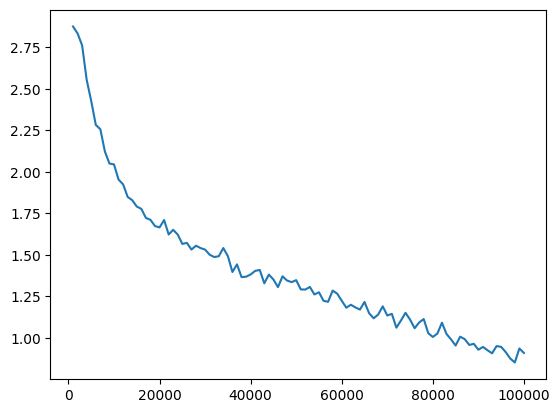

In [22]:
plt.figure()
plt.plot([x[0] for x in all_losses], [x[1] for x in all_losses])

# Evaluating on some inputs

In [23]:
def predict(name, n_predictions = 3):
    
    with torch.no_grad():
        
        hidden = rnn.initHidden()

        input = nameToTensor(name)

        output, hidden = rnn(input, hidden)
            
        top_k = output.topk(3, 0, True)
        
        top_lang_preds = [langs[index] for index in top_k[1]]
        
    return top_lang_preds

In [24]:
for i in range(10):
    lang, name = randomExample()
    
    preds = predict(name)
    
    print("Name: ", name)
    print("Language: ", lang)
    print("Predicted languages: ", ", ".join(preds))
    print()

Name:  Fukuda
Language:  Japanese
Predicted languages:  Japanese, Spanish, Czech

Name:  Zhikov
Language:  Russian
Predicted languages:  Russian, Czech, English

Name:  Kwak
Language:  Korean
Predicted languages:  Polish, Korean, Czech

Name:  Sasaki
Language:  Japanese
Predicted languages:  Japanese, Arabic, Polish

Name:  Ivor
Language:  Irish
Predicted languages:  English, German, French

Name:  Mikhaleiko
Language:  Russian
Predicted languages:  Russian, Japanese, Czech

Name:  Pazhinsky
Language:  Russian
Predicted languages:  Russian, Czech, English

Name:  Fonseca
Language:  Portuguese
Predicted languages:  Spanish, Portuguese, Italian

Name:  Chu
Language:  Vietnamese
Predicted languages:  Vietnamese, Chinese, Korean

Name:  Horn
Language:  English
Predicted languages:  Dutch, English, German



# Confusion Matrix

In [25]:
confusion = torch.zeros(n_langs, n_langs)
n_confusion = 10000

In [26]:
for i in range(n_confusion):
    lang, name = randomExample()
    
    preds = predict(name)
    pred = preds[0]
    
    pred = langs.index(pred)
    target = langs.index(lang)
    
    confusion[target][pred] += 1

In [27]:
for i in range(n_langs):
    confusion[i] /= confusion[i].sum()

/var/folders/dx/y8znj2hn5sv9_zwtm2h2y_zm0000gn/T/ipykernel_42705/3961177364.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + langs, rotation=90)
/var/folders/dx/y8znj2hn5sv9_zwtm2h2y_zm0000gn/T/ipykernel_42705/3961177364.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + langs)


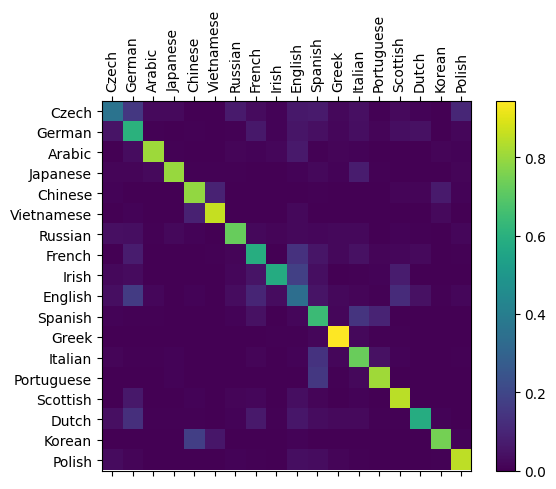

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + langs, rotation=90)
ax.set_yticklabels([''] + langs)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()